In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

c:\Learning\Labs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

path = "../datasets/ecommerce-analysis/"
orders = pd.read_csv(path + "olist_orders_dataset.csv")
order_items = pd.read_csv(path + "olist_order_items_dataset.csv")
products = pd.read_csv(path + "olist_products_dataset.csv")
customers = pd.read_csv(path + "olist_customers_dataset.csv")
sellers = pd.read_csv(path + "olist_sellers_dataset.csv")
payments = pd.read_csv(path + "olist_order_payments_dataset.csv")
reviews = pd.read_csv(path + "olist_order_reviews_dataset.csv")
geo = pd.read_csv(path + "olist_geolocation_dataset.csv")
categories = pd.read_csv(path + "product_category_name_translation.csv")


In [29]:
# Merge to get product category names
df = pd.merge(orders, order_items, on="order_id")
df = pd.merge(df, products[['product_id', 'product_category_name']], on="product_id", how="left")
df = pd.merge(df, categories, on="product_category_name", how="left")
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,housewares
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,perfumery
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,auto
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,pet_shop
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,stationery


In [30]:
basket = (df.groupby(['order_id', 'product_category_name_english'])['order_item_id']
            .count().unstack().reset_index().fillna(0)
            .set_index('order_id'))

# Convert counts to binary (1 = bought, 0 = not bought)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

print(basket.shape)
basket.head()

C:\Users\madhu\AppData\Local\Temp\ipykernel_27704\1803960526.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


(97256, 71)


product_category_name_english,agro_industry_and_commerce,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,...,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
order_id,,,,,,,,,,,,,,,,,,,,,
00010242fe8c5a6d1ba2dd792cb16214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00018f77f2f0320c557190d7a144bdd3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000229ec398224ef6ca0657da4fc703e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00024acbcdf0a6daa1e931b038114c75,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00042b26cf59d7ce69dfabb4e55b4fd9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
avg_products = basket.sum(axis=1).mean()
print("Average products per order:", avg_products)

Average products per order: 1.00761906720408


In [26]:
from mlxtend.frequent_patterns import fpgrowth

frequent_items_fp = fpgrowth(basket, min_support=0.002, use_colnames=True)
rules_fp = association_rules(frequent_items_fp, metric="confidence", min_threshold=0.2)

rules_fp = rules_fp.sort_values("confidence", ascending=False)
print(rules_fp[['antecedents','consequents','support','confidence','lift']].head(10))

c:\Learning\Labs\venv\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


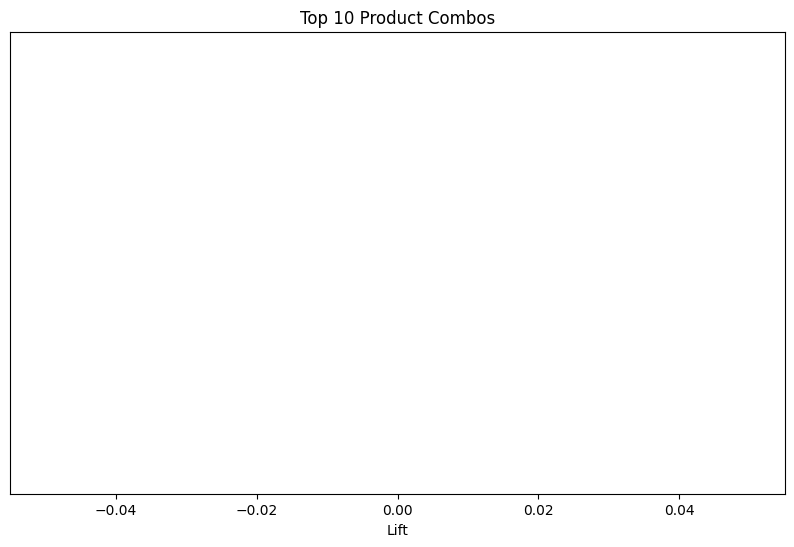

In [27]:
import matplotlib.pyplot as plt

top_rules = rules.sort_values("lift", ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(range(len(top_rules)), top_rules['lift'], color="skyblue")
plt.yticks(range(len(top_rules)),
           [f"{list(a)[0]} → {list(c)[0]}" for a,c in zip(top_rules['antecedents'], top_rules['consequents'])])
plt.xlabel("Lift")
plt.title("Top 10 Product Combos")
plt.gca().invert_yaxis()
plt.show()

In [32]:
import requests
response = requests.get('https://fakestoreapi.com/products/1')
print(response.json())

{'id': 1, 'title': 'Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops', 'price': 109.95, 'description': 'Your perfect pack for everyday use and walks in the forest. Stash your laptop (up to 15 inches) in the padded sleeve, your everyday', 'category': "men's clothing", 'image': 'https://fakestoreapi.com/img/81fPKd-2AYL._AC_SL1500_t.png', 'rating': {'rate': 3.9, 'count': 120}}
